In [1]:
from tkcalendar import DateEntry
import tkinter as tk
from tkinter import messagebox, ttk
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from flask import Flask, render_template, request, redirect, url_for
from flask_ngrok import run_with_ngrok
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
import threading
import yfinance as yf
from scipy.stats import norm, multivariate_normal
import scipy.stats as stats
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, GRU, MultiHeadAttention, Add, RepeatVector, GlobalAveragePooling1D, LayerNormalization, Embedding, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tcn import TCN, tcn_full_summary
import xgboost as xgb
import lightgbm as lgb
import warnings
from prophet import Prophet
import nest_asyncio
from threading import Thread
import time

# 1. Development of an Investment Simulation Web Application

## Fetching Historical Data for SPY, QQQ, and DIA

In [2]:
def fetch_etf_data(api_key, symbols):
    # Base URL for Alpha Vantage API
    base_url = 'https://www.alphavantage.co/query'
    
    # Dictionary to store DataFrames for each ETF symbol
    data_frames = {}

    for symbol in symbols:
        # Parameters for the API request
        params = {
            'function': 'TIME_SERIES_DAILY',  # Function for daily time series data
            'symbol': symbol,                 # ETF symbol
            'outputsize': 'full',             # Retrieve the full-length data
            'apikey': api_key                 # API key for authentication
        }
        
        # Send GET request to the API
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # Check if the data is returned successfully
        if 'Time Series (Daily)' in data:
            # Extract the time series data
            time_series = data['Time Series (Daily)']
            # Convert the time series data to a DataFrame
            df = pd.DataFrame.from_dict(time_series, orient='index')
            # Convert the index to datetime format
            df.index = pd.to_datetime(df.index)
            # Sort the DataFrame by date
            df = df.sort_index()
            # Rename the columns to more readable names
            df.columns = ['open', 'high', 'low', 'close', 'volume']
            # Store the DataFrame in the dictionary
            data_frames[symbol] = df
        else:
            # Print an error message if data retrieval fails
            print(f"Error fetching data for {symbol}: {data}")
    
    # Return the dictionary of DataFrames
    return data_frames

# Use the API key to fetch data for SPY, QQQ, and DIA ETFs
api_key = 'OMMJ4N8YIMXKICMH'
symbols = ['SPY', 'QQQ', 'DIA']
etf_data = fetch_etf_data(api_key, symbols)
spy_data = etf_data['SPY']
qqq_data = etf_data['QQQ']
dia_data = etf_data['DIA'] 


In [7]:
# Function to save DataFrame as a TXT file
def save_to_txt(df, filename):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    # Ensure the DataFrame has the correct columns
    if df_copy.shape[1] == 5:
        # Add the date column from the index
        df_copy.reset_index(inplace=True)
        df_copy.rename(columns={'index': 'date'}, inplace=True)
        # Save the DataFrame to a TXT file
        df_copy.to_csv(filename, sep='\t', index=False)
    else:
        print(f"Unexpected number of columns in DataFrame: {df_copy.shape[1]}")

# Ensure the cache directory exists
CACHE_DIR = 'cache_data'
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

# Save SPY data as TXT
save_to_txt(spy_data, os.path.join(CACHE_DIR, 'spy_data.txt'))

# Save QQQ data as TXT
save_to_txt(qqq_data, os.path.join(CACHE_DIR, 'qqq_data.txt'))

# Save DIA data as TXT
save_to_txt(dia_data, os.path.join(CACHE_DIR, 'dia_data.txt'))


In [9]:
# Read the data back from the TXT files
spy_data = pd.read_csv(os.path.join(CACHE_DIR, 'spy_data.txt'), sep='\t', parse_dates=['date'], index_col='date')
qqq_data = pd.read_csv(os.path.join(CACHE_DIR, 'qqq_data.txt'), sep='\t', parse_dates=['date'], index_col='date')
dia_data = pd.read_csv(os.path.join(CACHE_DIR, 'dia_data.txt'), sep='\t', parse_dates=['date'], index_col='date')
etf_data = {'SPY': spy_data, 'QQQ': qqq_data, 'DIA': dia_data}

## Designing a Web Application for Investment Simulation Using Historical Data

In [11]:
def simulate_investment():
    try:
        symbol = symbol_var.get().upper()
        start_date = entry_start_date.get_date()
        end_date = entry_end_date.get_date()
        starting_principal = float(entry_principal.get())
        auto_invest_amount = float(entry_auto_invest.get())
        investment_day = investment_day_var.get()
        frequency = frequency_var.get()
        
        # Validate symbol
        if symbol not in etf_data:
            raise ValueError("Invalid ETF symbol. Please select SPY, QQQ, or DIA.")
        
        # Convert dates
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        # Check date validity
        if start_date >= end_date:
            raise ValueError("Start date must be earlier than end date.")
        
        # Fetch ETF data
        df = etf_data[symbol]
        df = df[(df.index >= start_date) & (df.index <= end_date)]
        
        if df.empty:
            raise ValueError("No data available for the selected date range.")
        
        # Ensure date index is unique and sorted
        df = df.sort_index()
        df = df.loc[~df.index.duplicated(keep='first')]
        
        # Reset investment variables
        total_invested = starting_principal  # Start with the initial principal
        total_shares = starting_principal / float(df.iloc[0]['close'])
        current_balance = total_shares * float(df.iloc[0]['close'])
        
        # Track investment over time
        investment_values = [current_balance]
        total_investment_values = [total_invested]  # Start with the initial principal
        dates = [start_date]
        
        interval_days = {'weekly': 7, 'bi-weekly': 14, 'monthly': 30}
        
        date = start_date + timedelta(days=1)
        investment_interval = interval_days[frequency]
        last_investment_date = start_date
        while date <= end_date:
            if date in df.index:
                if (date - last_investment_date).days >= investment_interval and date.strftime('%A') == investment_day:
                    total_invested += auto_invest_amount
                    total_shares += auto_invest_amount / float(df.loc[date]['close'])
                    last_investment_date = date
                current_balance = total_shares * float(df.loc[date]['close'])
            
                # Record the values for plotting
                investment_values.append(current_balance)
                total_investment_values.append(total_invested)
                dates.append(date)
            
            date += timedelta(days=1)
        
        # Final calculation
        current_balance = total_shares * float(df.iloc[-1]['close'])
        profit = current_balance - total_invested
        monthly_savings = profit / ((end_date - start_date).days / 30)
        
        # Plot the results
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1]})  # Adjust figure size and ratio
        
        # Investment value plot
        ax1.plot(dates, investment_values, label='Investment Value Over Time')
        ax1.plot(dates, total_investment_values, label='Total Investment', linestyle='--')
        ax1.axhline(y=starting_principal, color='r', linestyle='--', label='Starting Principal')
        ax1.set_title(f'{symbol} Investment Simulation')
        ax1.set_xlabel('')  # Remove X-axis label to reduce overlap
        ax1.set_ylabel('Investment Value (USD)')
        ax1.legend()

        # Profit rate plot
        profit_rates = [iv / ti for iv, ti in zip(investment_values, total_investment_values)]
        ax2.plot(dates, profit_rates, label='Profit Rate Over Time')
        ax2.set_title(f'{symbol} Profit Rate Simulation')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Profit Rate')
        ax2.legend()

        plt.tight_layout()  # Adjust layout to avoid overlap

        # Clear the previous plot
        for widget in plot_frame.winfo_children():
            widget.destroy()

        # Embed the plot in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        result_label.config(text=f"Starting Principal: ${starting_principal:.2f}\n"
                                 f"Total Invested: ${total_invested:.2f}\n"
                                 f"Total Shares: {total_shares:.2f}\n"
                                 f"Current Balance: ${current_balance:.2f}\n"
                                 f"Profit: ${profit:.2f}\n"
                                 f"Monthly Potential Profit: ${monthly_savings:.2f}")

        # Return investment details for further analysis
        investment_details = pd.DataFrame({
            'Date': dates,
            'Investment Value': investment_values,
            'Total Investment': total_investment_values,
            'Profit Rate': profit_rates
        })
        return investment_details
    
    except Exception as e:
        messagebox.showerror("Input Error", str(e))

# Create the main GUI window
root = tk.Tk()
root.title("ETF Investment Simulation")
root.geometry("1000x1300")  # Adjust window size to reduce blank areas

# Set today's date and the minimum date
today = datetime.today()
min_date = datetime(1999, 1, 1)
max_date = today - timedelta(days=1)

# Main frame
main_frame = ttk.Frame(root, padding="10")
main_frame.pack(fill=tk.BOTH, expand=True)

# Input frame
input_frame = ttk.LabelFrame(main_frame, text="Investment Details", padding="10")
input_frame.pack(fill=tk.X, expand=True, pady=10)  # Only fill on X-axis

# Labels and Entry widgets for user input
ttk.Label(input_frame, text="ETF Symbol:").grid(column=0, row=0, sticky=tk.W, padx=5, pady=5)
symbol_var = tk.StringVar(value='SPY')
symbol_menu = ttk.OptionMenu(input_frame, symbol_var, 'SPY', 'SPY', 'QQQ', 'DIA')
symbol_menu.grid(column=1, row=0, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame, text="Start Date:").grid(column=0, row=1, sticky=tk.W, padx=5, pady=5)
entry_start_date = DateEntry(input_frame, min_date=min_date, max_date=max_date, date_pattern='yyyy-MM-dd')
entry_start_date.grid(column=1, row=1, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame, text="End Date:").grid(column=0, row=2, sticky=tk.W, padx=5, pady=5)
entry_end_date = DateEntry(input_frame, min_date=min_date, max_date=max_date, date_pattern='yyyy-MM-dd')
entry_end_date.grid(column=1, row=2, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame, text="Starting Principal:").grid(column=0, row=3, sticky=tk.W, padx=5, pady=5)
entry_principal = ttk.Entry(input_frame)
entry_principal.grid(column=1, row=3, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame, text="Auto Invest Amount:").grid(column=0, row=4, sticky=tk.W, padx=5, pady=5)
entry_auto_invest = ttk.Entry(input_frame)
entry_auto_invest.grid(column=1, row=4, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame, text="Investment Interval (day of the week):").grid(column=0, row=5, sticky=tk.W, padx=5, pady=5)
investment_day_var = tk.StringVar(value='Monday')
investment_day_menu = ttk.OptionMenu(input_frame, investment_day_var, 'Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
investment_day_menu.grid(column=1, row=5, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame, text="Frequency:").grid(column=0, row=6, sticky=tk.W, padx=5, pady=5)
frequency_var = tk.StringVar(value='weekly')
frequency_menu = ttk.OptionMenu(input_frame, frequency_var, 'weekly', 'weekly', 'bi-weekly', 'monthly')
frequency_menu.grid(column=1, row=6, sticky=tk.EW, padx=5, pady=5)

# Button to simulate investment
simulate_button = ttk.Button(main_frame, text="Simulate Investment", command=simulate_investment)
simulate_button.pack(pady=10)

# Frame to display the plot
plot_frame = ttk.Frame(main_frame)
plot_frame.pack(fill=tk.BOTH, expand=True)

# Label to display results
result_frame = ttk.LabelFrame(main_frame, text="Results", padding="10")
result_frame.pack(fill=tk.X, expand=True, pady=10)  # Only fill on X-axis
result_label = ttk.Label(result_frame, text="", justify=tk.LEFT)
result_label.pack(fill=tk.X, expand=True)

# Configure columns
for frame in [input_frame, result_frame]:
    for i in range(2):
        frame.columnconfigure(i, weight=1)

# Start the GUI main loop
root.mainloop()

In [ ]:
# Function to calculate investment metrics
def calculate_metrics(df, investment_values, total_investment_values, dates):
    # Overall profit
    overall_profit = investment_values[-1] - total_investment_values[-1]
    profit_percentage = (overall_profit / total_investment_values[-1]) * 100

    # Yearly metrics
    df['Year'] = df.index.year
    year_groups = df.groupby('Year')
    best_year_return = max([group.iloc[-1]['close'] / group.iloc[0]['close'] - 1 for name, group in year_groups])
    worst_year_return = min([group.iloc[-1]['close'] / group.iloc[0]['close'] - 1 for name, group in year_groups])
    years = (dates[-1] - dates[0]).days / 365
    per_year_profit = (investment_values[-1] / total_investment_values[-1]) ** (1/years) - 1

    # Volatility (Standard Deviation of returns)
    returns = df['close'].pct_change().dropna()
    volatility = returns.std() * np.sqrt(252)  # Annualize the volatility

    # Maximum drawdown
    cumulative_returns = (1 + returns).cumprod()
    drawdown = 1 - cumulative_returns / cumulative_returns.cummax()
    max_drawdown = drawdown.max()

    # Sharpe Ratio (Assuming risk-free rate is 0)
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)

    # Sortino Ratio (Assuming risk-free rate is 0)
    downside_returns = returns[returns < 0]
    sortino_ratio = returns.mean() / downside_returns.std() * np.sqrt(252)

    return {
        'overall_profit': overall_profit,
        'profit_percentage': profit_percentage,
        'per_year_profit': per_year_profit,
        'best_year_return': best_year_return,
        'worst_year_return': worst_year_return,
        'volatility': volatility,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio
    }

def simulate_investment():
    try:
        symbol = symbol_var.get().upper()
        start_date = entry_start_date.get_date()
        end_date = entry_end_date.get_date()
        starting_principal = float(entry_principal.get())
        auto_invest_amount = float(entry_auto_invest.get())
        investment_day = investment_day_var.get()
        frequency = frequency_var.get()
        
        # Convert dates
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        # Check date validity
        if start_date >= end_date:
            raise ValueError("Start date must be earlier than end date.")
        
        # Fetch ETF data
        df = etf_data[symbol]
        df = df[(df.index >= start_date) & (df.index <= end_date)]
        
        if df.empty:
            raise ValueError("No data available for the selected date range.")
        
        # Ensure date index is unique and sorted
        df = df.sort_index()
        df = df.loc[~df.index.duplicated(keep='first')]
        
        # Reset investment variables
        total_invested = starting_principal  # Start with the initial principal
        total_shares = starting_principal / float(df.iloc[0]['close'])
        current_balance = total_shares * float(df.iloc[0]['close'])
        
        # Track investment over time
        investment_values = [current_balance]
        total_investment_values = [total_invested]  # Start with the initial principal
        dates = [start_date]
        
        interval_days = {'weekly': 7, 'bi-weekly': 14, 'monthly': 30}
        
        date = start_date + timedelta(days=1)
        investment_interval = interval_days[frequency]
        last_investment_date = start_date
        while date <= end_date:
            if date in df.index:
                if (date - last_investment_date).days >= investment_interval and date.strftime('%A') == investment_day:
                    total_invested += auto_invest_amount
                    total_shares += auto_invest_amount / float(df.loc[date]['close'])
                    last_investment_date = date
                current_balance = total_shares * float(df.loc[date]['close'])
            
                # Record the values for plotting
                investment_values.append(current_balance)
                total_investment_values.append(total_invested)
                dates.append(date)
            
            date += timedelta(days=1)
        
        # Final calculation
        current_balance = total_shares * float(df.iloc[-1]['close'])
        profit = current_balance - total_invested
        monthly_savings = profit / ((end_date - start_date).days / 30)
        
        # Calculate the additional metrics
        metrics = calculate_metrics(df, investment_values, total_investment_values, dates)
        
        # Plot the results
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1]})  # Adjust figure size and ratio
        
        # Investment value plot
        ax1.plot(dates, investment_values, label='Investment Value Over Time')
        ax1.plot(dates, total_investment_values, label='Total Investment', linestyle='--')
        ax1.axhline(y=starting_principal, color='r', linestyle='--', label='Starting Principal')
        ax1.set_title(f'{symbol} Investment Simulation')
        ax1.set_xlabel('')  # Remove X-axis label to reduce overlap
        ax1.set_ylabel('Investment Value (USD)')
        ax1.legend()

        # Profit rate plot
        profit_rates = [iv / ti for iv, ti in zip(investment_values, total_investment_values)]
        ax2.plot(dates, profit_rates, label='Profit Rate Over Time')
        ax2.set_title(f'{symbol} Profit Rate Simulation')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Profit Rate')
        ax2.legend()

        plt.tight_layout()  # Adjust layout to avoid overlap

        # Clear the previous plot
        for widget in plot_frame.winfo_children():
            widget.destroy()

        # Embed the plot in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Display the results in the label
        result_label.config(text=(
            f"Starting Principal: ${starting_principal:.2f}\n"
            f"Total Invested: ${total_invested:.2f}\n"
            f"Total Shares: {total_shares:.2f}\n"
            f"Current Balance: ${current_balance:.2f}\n"
            f"Profit: ${profit:.2f}\n"
            f"Monthly Potential Profit: ${monthly_savings:.2f}\n"
            f"Overall Profit: ${metrics['overall_profit']:.2f} ({metrics['profit_percentage']:.2f}%)\n"
            f"Per Year Profit: {metrics['per_year_profit']:.2f}\n"
            f"Best Year Return: {metrics['best_year_return']:.2f}\n"
            f"Worst Year Return: {metrics['worst_year_return']:.2f}\n"
            f"Volatility: {metrics['volatility']:.2f}\n"
            f"Max Drawdown: {metrics['max_drawdown']:.2f}\n"
            f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}\n"
            f"Sortino Ratio: {metrics['sortino_ratio']:.2f}"
        ))

        # Return investment details for further analysis
        investment_details = pd.DataFrame({
            'Date': dates,
            'Investment Value': investment_values,
            'Total Investment': total_investment_values,
            'Profit Rate': profit_rates
        })
        return investment_details
    
    except Exception as e:
        messagebox.showerror("Input Error", str(e))

def check_inputs(*args):
    if symbol_var.get() and entry_start_date.get() and entry_end_date.get() and entry_principal.get() and entry_auto_invest.get() and investment_day_var.get() != "Select a day" and frequency_var.get() != "Select a frequency":
        simulate_button.config(state=tk.NORMAL)
    else:
        simulate_button.config(state=tk.DISABLED)

# Create the main GUI window
root = tk.Tk()
root.title("ETF Investment Simulator")
root.geometry("600x600")

# Configure the main frame with padding and expand options
main_frame = ttk.Frame(root, padding="20")
main_frame.pack(fill=tk.BOTH, expand=True)

# Add a stylish title
title_label = ttk.Label(main_frame, text="ETF Investment Simulator", font=("Helvetica", 18, "bold"))
title_label.pack(pady=(0, 20))

# Input frame with some padding
input_frame = ttk.Frame(main_frame)
input_frame.pack(fill=tk.BOTH, expand=True)

# Function to create labeled input fields
def create_input_field(label_text, var, row, column, **kwargs):
    ttk.Label(input_frame, text=label_text).grid(row=row, column=column, sticky=tk.W, padx=5, pady=5)
    entry = ttk.Entry(input_frame, textvariable=var, **kwargs)
    entry.grid(row=row, column=column+1, sticky=tk.EW, padx=5, pady=5)
    return entry

# ETF Symbol dropdown
symbol_var = tk.StringVar()
ttk.Label(input_frame, text="ETF Symbol:").grid(row=0, column=0, sticky=tk.W, padx=5, pady=5)
symbol_menu = ttk.OptionMenu(input_frame, symbol_var, 'Select an ETF', 'SPY', 'QQQ', 'DIA')
symbol_menu.grid(row=0, column=1, sticky=tk.EW, padx=5, pady=5)

# Start Date input
start_date_var = tk.StringVar()
entry_start_date = DateEntry(input_frame, textvariable=start_date_var, date_pattern='mm/dd/yyyy', width=18)
ttk.Label(input_frame, text="Start Date:").grid(row=1, column=0, sticky=tk.W, padx=5, pady=5)
entry_start_date.grid(row=1, column=1, sticky=tk.EW, padx=5, pady=5)

# End Date input
end_date_var = tk.StringVar()
entry_end_date = DateEntry(input_frame, textvariable=end_date_var, date_pattern='mm/dd/yyyy', width=18)
ttk.Label(input_frame, text="End Date:").grid(row=2, column=0, sticky=tk.W, padx=5, pady=5)
entry_end_date.grid(row=2, column=1, sticky=tk.EW, padx=5, pady=5)

# Starting Principal input
principal_var = tk.StringVar()
entry_principal = create_input_field("Starting Principal ($):", principal_var, 3, 0)

# Auto Invest Amount input
auto_invest_var = tk.StringVar()
entry_auto_invest = create_input_field("Auto Invest Amount ($):", auto_invest_var, 4, 0)

# Frequency dropdown
frequency_var = tk.StringVar(value='Select a frequency')
ttk.Label(input_frame, text="Frequency:").grid(row=5, column=0, sticky=tk.W, padx=5, pady=5)
frequency_menu = ttk.OptionMenu(input_frame, frequency_var, 'Select a frequency', 'weekly', 'bi-weekly', 'monthly')
frequency_menu.grid(row=5, column=1, sticky=tk.EW, padx=5, pady=5)

# Investment Interval dropdown
investment_day_var = tk.StringVar(value='Select a day')
ttk.Label(input_frame, text="Investment Interval:").grid(row=6, column=0, sticky=tk.W, padx=5, pady=5)
investment_day_menu = ttk.OptionMenu(input_frame, investment_day_var, 'Select a day', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
investment_day_menu.grid(row=6, column=1, sticky=tk.EW, padx=5, pady=5)

# Button to simulate investment, initially disabled
simulate_button = ttk.Button(main_frame, text="Simulate Returns", command=lambda: None, state=tk.DISABLED)
simulate_button.pack(pady=20)

# Tracking input changes to enable/disable the button
symbol_var.trace_add("write", check_inputs)
start_date_var.trace_add("write", check_inputs)
end_date_var.trace_add("write", check_inputs)
principal_var.trace_add("write", check_inputs)
auto_invest_var.trace_add("write", check_inputs)
frequency_var.trace_add("write", check_inputs)
investment_day_var.trace_add("write", check_inputs)

# Start the GUI main loop
root.mainloop()

## Designing a Web Application for Comparing Different Investment Simulation Strategies Using Historical Data

In [6]:
def simulate_investment():
    try:
        # Get user inputs for the first ETF (Left Side)
        symbol1 = symbol_var1.get().upper()
        start_date1 = entry_start_date1.get_date()
        end_date1 = entry_end_date1.get_date()
        starting_principal1 = float(entry_principal1.get())
        auto_invest_amount1 = float(entry_auto_invest1.get())
        investment_day1 = investment_day_var1.get()
        frequency1 = frequency_var1.get()

        # Get user inputs for the second ETF (Right Side) with fallback to first ETF's inputs
        symbol2 = symbol_var2.get().upper() if symbol_var2.get() else symbol1
        start_date2 = entry_start_date2.get_date() if entry_start_date2.get() else start_date1
        end_date2 = entry_end_date2.get_date() if entry_end_date2.get() else end_date1
        starting_principal2 = float(entry_principal2.get()) if entry_principal2.get() else starting_principal1
        auto_invest_amount2 = float(entry_auto_invest2.get()) if entry_auto_invest2.get() else auto_invest_amount1
        investment_day2 = investment_day_var2.get() if investment_day_var2.get() else investment_day1
        frequency2 = frequency_var2.get() if frequency_var2.get() else frequency1

        # Convert dates to datetime
        start_date1 = pd.to_datetime(start_date1)
        end_date1 = pd.to_datetime(end_date1)
        start_date2 = pd.to_datetime(start_date2)
        end_date2 = pd.to_datetime(end_date2)

        # Check date validity for both ETFs
        if start_date1 >= end_date1 or start_date2 >= end_date2:
            raise ValueError("Start date must be earlier than end date.")

        # Interval mapping
        interval_days = {'weekly': 7, 'bi-weekly': 14, 'monthly': 30}

        # Prepare the plot
        fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

        # Simulate for the first ETF (Left Side)
        investment_values1, total_investment_values1, profit_rates1, dates1, final_balance1, total_invested1, total_shares1 = simulate_single_etf(
            symbol1, start_date1, end_date1, starting_principal1, auto_invest_amount1,
            investment_day1, frequency1, interval_days, ax[0]
        )

        # Simulate for the second ETF (Right Side)
        investment_values2, total_investment_values2, profit_rates2, dates2, final_balance2, total_invested2, total_shares2 = simulate_single_etf(
            symbol2, start_date2, end_date2, starting_principal2, auto_invest_amount2,
            investment_day2, frequency2, interval_days, ax[0]
        )

        # Plot the profit rate on the second axis
        ax[1].plot(dates1, profit_rates1, label=f'{symbol1} Profit Rate', color='blue')
        ax[1].plot(dates2, profit_rates2, label=f'{symbol2} Profit Rate', color='orange')

        # Add legends to both axes
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')

        ax[0].set_title("Investment Value and Total Investment Over Time")
        ax[1].set_title("Profit Rate Over Time")

        ax[0].set_ylabel("USD")
        ax[1].set_ylabel("Profit Rate")
        ax[1].set_xlabel("Date")

        plt.tight_layout()

        # Clear the previous plot
        for widget in plot_frame.winfo_children():
            widget.destroy()

        # Embed the plot in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Calculate and display monthly profit
        months1 = (end_date1 - start_date1).days / 30.44  # Approximate number of months
        monthly_profit1 = (final_balance1 - total_invested1) / months1

        months2 = (end_date2 - start_date2).days / 30.44  # Approximate number of months
        monthly_profit2 = (final_balance2 - total_invested2) / months2

        # Update the result labels with the simulation results
        result_label_left.config(text=f"Starting Principal: ${starting_principal1:.2f}\n"
                                      f"Total Invested: ${total_invested1:.2f}\n"
                                      f"Total Shares: {total_shares1:.2f}\n"
                                      f"Current Balance: ${final_balance1:.2f}\n"
                                      f"Profit: ${final_balance1 - total_invested1:.2f}\n"
                                      f"Monthly Profit: ${monthly_profit1:.2f}")

        result_label_right.config(text=f"Starting Principal: ${starting_principal2:.2f}\n"
                                       f"Total Invested: ${total_invested2:.2f}\n"
                                       f"Total Shares: {total_shares2:.2f}\n"
                                       f"Current Balance: ${final_balance2:.2f}\n"
                                       f"Profit: ${final_balance2 - total_invested2:.2f}\n"
                                       f"Monthly Profit: ${monthly_profit2:.2f}")

    except Exception as e:
        messagebox.showerror("Input Error", str(e))


def simulate_single_etf(symbol, start_date, end_date, starting_principal, auto_invest_amount, investment_day, frequency, interval_days, ax):
    # Fetch ETF data
    df = etf_data[symbol]
    df = df[(df.index >= start_date) & (df.index <= end_date)]

    if df.empty:
        raise ValueError(f"No data available for {symbol} in the selected date range.")

    # Ensure date index is unique and sorted
    df = df.sort_index()
    df = df.loc[~df.index.duplicated(keep='first')]

    # Initialize investment variables
    total_invested = starting_principal  # Start with initial principal
    total_shares = starting_principal / float(df.iloc[0]['close'])
    current_balance = total_shares * float(df.iloc[0]['close'])

    # Track investment over time
    investment_values = [current_balance]
    total_investment_values = [total_invested]
    profit_rates = [current_balance / total_invested]
    dates = [start_date]

    # Determine investment interval
    investment_interval = interval_days[frequency]
    last_investment_date = start_date

    # Loop through each day in the date range
    date = start_date + timedelta(days=1)
    while date <= end_date:
        if date in df.index:
            # Check if it's time to invest according to the interval and day of the week
            if (date - last_investment_date).days >= investment_interval and date.strftime('%A') == investment_day:
                total_invested += auto_invest_amount
                total_shares += auto_invest_amount / float(df.loc[date]['close'])
                last_investment_date = date
            current_balance = total_shares * float(df.loc[date]['close'])

            # Record the values for plotting
            investment_values.append(current_balance)
            total_investment_values.append(total_invested)
            profit_rates.append(current_balance / total_invested)
            dates.append(date)

        date += timedelta(days=1)

    # Plot investment value over time
    ax.plot(dates, investment_values, label=f'{symbol} ({frequency})')
    ax.plot(dates, total_investment_values, label=f'{symbol} Total Investment', linestyle='--')

    # Return data for further plotting in the main function
    return investment_values, total_investment_values, profit_rates, dates, current_balance, total_invested, total_shares


# Create the main GUI window
root = tk.Tk()
root.title("ETF Investment Simulation")
root.geometry("1500x1400")  # Adjust window size to fit both sets of inputs side by side

# Set today's date and the minimum date
today = datetime.today()
min_date = datetime(1999, 1, 1)
max_date = today - timedelta(days=1)

# Main frame to hold all input and output widgets
main_frame = ttk.Frame(root, padding="10")
main_frame.pack(fill=tk.BOTH, expand=True)

# Input frame - Left Side
input_frame_left = ttk.LabelFrame(main_frame, text="Investment Details 1", padding="10")
input_frame_left.grid(column=0, row=0, padx=5, pady=5, sticky="nsew")  # Grid to place it in the top left

# Input frame - Right Side
input_frame_right = ttk.LabelFrame(main_frame, text="Investment Details 2", padding="10")
input_frame_right.grid(column=1, row=0, padx=5, pady=5, sticky="nsew")  # Grid to place it in the top right

# Set the column weights for the main frame so they evenly distribute the space
main_frame.columnconfigure(0, weight=1)
main_frame.columnconfigure(1, weight=1)

# Labels and Entry widgets for user input - Left Side
ttk.Label(input_frame_left, text="ETF Symbol:").grid(column=0, row=0, sticky=tk.W, padx=5, pady=5)
symbol_var1 = tk.StringVar(value='SPY')
symbol_menu1 = ttk.OptionMenu(input_frame_left, symbol_var1, 'SPY', 'SPY', 'QQQ', 'DIA')
symbol_menu1.grid(column=1, row=0, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_left, text="Start Date:").grid(column=0, row=1, sticky=tk.W, padx=5, pady=5)
entry_start_date1 = DateEntry(input_frame_left, min_date=min_date, max_date=max_date, date_pattern='yyyy-MM-dd')
entry_start_date1.grid(column=1, row=1, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_left, text="End Date:").grid(column=0, row=2, sticky=tk.W, padx=5, pady=5)
entry_end_date1 = DateEntry(input_frame_left, min_date=min_date, max_date=max_date, date_pattern='yyyy-MM-dd')
entry_end_date1.grid(column=1, row=2, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_left, text="Starting Principal:").grid(column=0, row=3, sticky=tk.W, padx=5, pady=5)
entry_principal1 = ttk.Entry(input_frame_left)
entry_principal1.grid(column=1, row=3, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_left, text="Auto Invest Amount:").grid(column=0, row=4, sticky=tk.W, padx=5, pady=5)
entry_auto_invest1 = ttk.Entry(input_frame_left)
entry_auto_invest1.grid(column=1, row=4, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_left, text="Investment Interval (day of the week):").grid(column=0, row=5, sticky=tk.W, padx=5, pady=5)
investment_day_var1 = tk.StringVar(value='Monday')
investment_day_menu1 = ttk.OptionMenu(input_frame_left, investment_day_var1, 'Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
investment_day_menu1.grid(column=1, row=5, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_left, text="Frequency:").grid(column=0, row=6, sticky=tk.W, padx=5, pady=5)
frequency_var1 = tk.StringVar(value='weekly')
frequency_menu1 = ttk.OptionMenu(input_frame_left, frequency_var1, 'weekly', 'weekly', 'bi-weekly', 'monthly')
frequency_menu1.grid(column=1, row=6, sticky=tk.EW, padx=5, pady=5)

# Labels and Entry widgets for user input - Right Side (default to left if empty)
ttk.Label(input_frame_right, text="ETF Symbol:").grid(column=0, row=0, sticky=tk.W, padx=5, pady=5)
symbol_var2 = tk.StringVar(value='')
symbol_menu2 = ttk.OptionMenu(input_frame_right, symbol_var2, '', 'SPY', 'QQQ', 'DIA')
symbol_menu2.grid(column=1, row=0, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_right, text="Start Date:").grid(column=0, row=1, sticky=tk.W, padx=5, pady=5)
entry_start_date2 = DateEntry(input_frame_right, min_date=min_date, max_date=max_date, date_pattern='yyyy-MM-dd')
entry_start_date2.grid(column=1, row=1, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_right, text="End Date:").grid(column=0, row=2, sticky=tk.W, padx=5, pady=5)
entry_end_date2 = DateEntry(input_frame_right, min_date=min_date, max_date=max_date, date_pattern='yyyy-MM-dd')
entry_end_date2.grid(column=1, row=2, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_right, text="Starting Principal:").grid(column=0, row=3, sticky=tk.W, padx=5, pady=5)
entry_principal2 = ttk.Entry(input_frame_right)
entry_principal2.grid(column=1, row=3, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_right, text="Auto Invest Amount:").grid(column=0, row=4, sticky=tk.W, padx=5, pady=5)
entry_auto_invest2 = ttk.Entry(input_frame_right)
entry_auto_invest2.grid(column=1, row=4, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_right, text="Investment Interval (day of the week):").grid(column=0, row=5, sticky=tk.W, padx=5, pady=5)
investment_day_var2 = tk.StringVar(value='')
investment_day_menu2 = ttk.OptionMenu(input_frame_right, investment_day_var2, '', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
investment_day_menu2.grid(column=1, row=5, sticky=tk.EW, padx=5, pady=5)

ttk.Label(input_frame_right, text="Frequency:").grid(column=0, row=6, sticky=tk.W, padx=5, pady=5)
frequency_var2 = tk.StringVar(value='')
frequency_menu2 = ttk.OptionMenu(input_frame_right, frequency_var2, '', 'weekly', 'bi-weekly', 'monthly')
frequency_menu2.grid(column=1, row=6, sticky=tk.EW, padx=5, pady=5)

# Button to simulate investment
simulate_button = ttk.Button(main_frame, text="Simulate Investment", command=simulate_investment)
simulate_button.grid(column=0, row=1, columnspan=2, pady=10)  # Span across both input frames

# Frame to display the plot
plot_frame = ttk.Frame(main_frame)
plot_frame.grid(column=0, row=2, columnspan=2, sticky="nsew", padx=10, pady=10)

# Label to display results - Left Side
result_frame_left = ttk.LabelFrame(main_frame, text="Results 1", padding="10")
result_frame_left.grid(column=0, row=3, padx=5, pady=5, sticky="nsew")  # Left side result

result_label_left = ttk.Label(result_frame_left, text="", justify=tk.LEFT)
result_label_left.pack(fill=tk.X, expand=True)

# Label to display results - Right Side
result_frame_right = ttk.LabelFrame(main_frame, text="Results 2", padding="10")
result_frame_right.grid(column=1, row=3, padx=5, pady=5, sticky="nsew")  # Right side result

result_label_right = ttk.Label(result_frame_right, text="", justify=tk.LEFT)
result_label_right.pack(fill=tk.X, expand=True)

# Configure columns and rows for proper layout
for frame in [input_frame_left, input_frame_right, result_frame_left, result_frame_right]:
    for i in range(2):
        frame.columnconfigure(i, weight=1)

# Start the GUI main loop
root.mainloop()


The above GUI allows users to input ETF Symbols, start date, end date, starting principal, auto-investment amount, frequency, and investment interval (day of the week). It will output the total investment amount, total shares, profit, monthly profit, and provide two charts: the first showing the investment value over time along with the total investment, and the second showing the profit rate over time.

# 2. Designing an Predictive Web Application for Investment Simulation

## Fetching Historical Data for Indices from Yahoo Finance and Data Visualization

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


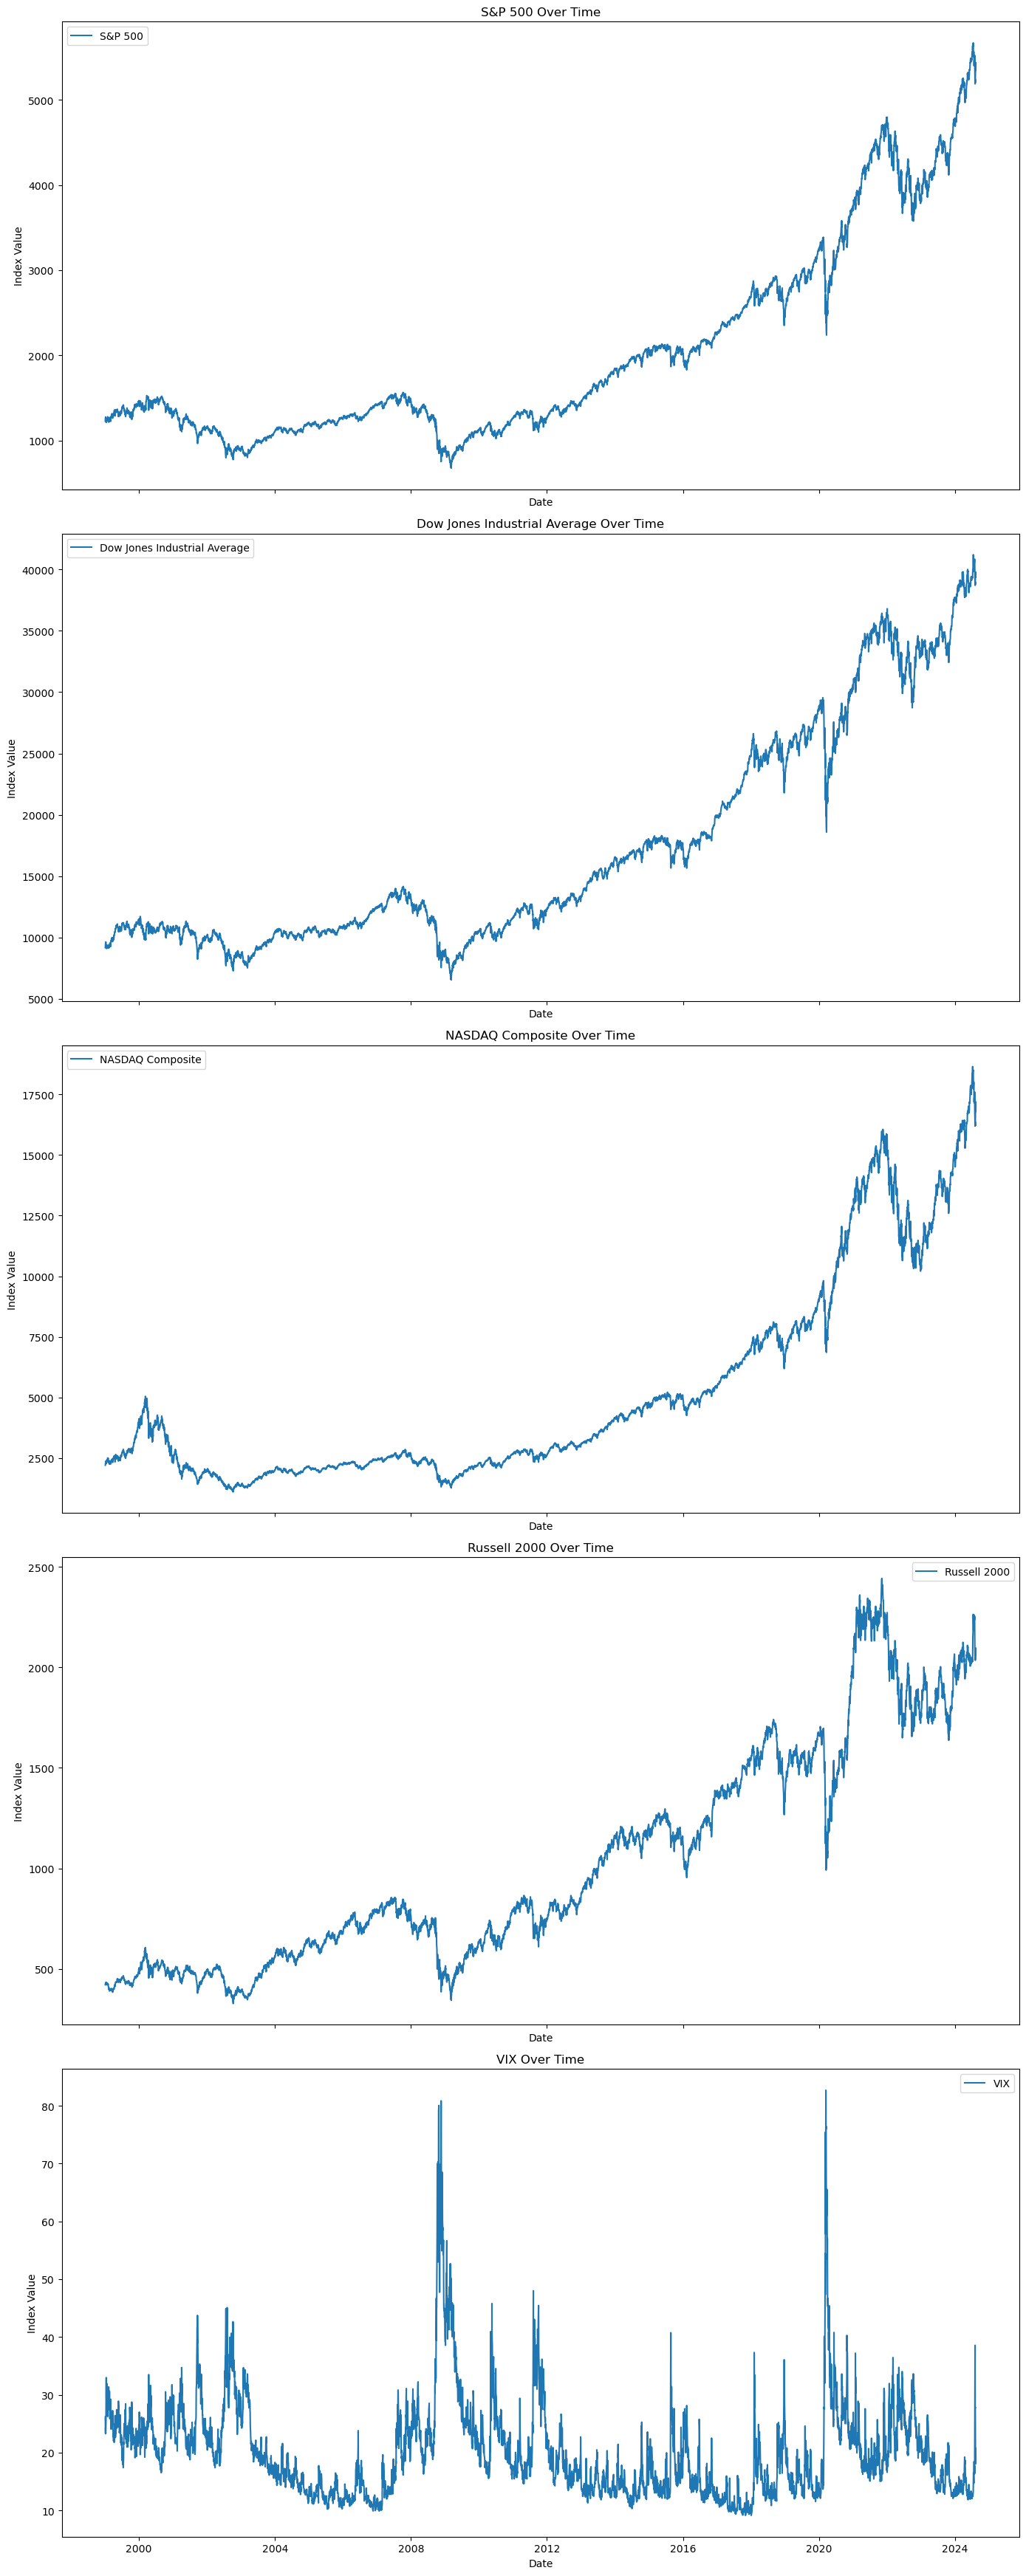

In [13]:
def fetch_and_save_indices_data(start_date='1999-01-01', end_date=None):
    """
    Fetch and save indices data from Yahoo Finance.

    Parameters:
    start_date (str): The start date for fetching data in the format 'YYYY-MM-DD'.
    end_date (str): The end date for fetching data in the format 'YYYY-MM-DD'. If None, fetches data up to the latest available date.
    
    Returns:
    pd.DataFrame: DataFrame containing the fetched indices data.
    """
    # Define the indices to fetch
    indices = {
        'S&P 500': '^GSPC',
        'Dow Jones Industrial Average': '^DJI',
        'NASDAQ Composite': '^IXIC',
        'Russell 2000': '^RUT',
        'VIX': '^VIX'
    }

    # If no end date is provided, use today's date
    if end_date is None:
        end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

    # Fetch data from Yahoo Finance
    data = {}
    for index_name, ticker in indices.items():
        data[index_name] = yf.download(ticker, start=start_date, end=end_date)['Close']

    # Combine all indices data into a single DataFrame
    df_indices = pd.DataFrame(data)

    # Plot each index in a separate subplot
    fig, axes = plt.subplots(len(indices), 1, figsize=(14, 7 * len(indices)), sharex=True)
    for i, (index_name, ticker) in enumerate(indices.items()):
        axes[i].plot(df_indices.index, df_indices[index_name])
        axes[i].set_title(f'{index_name} Over Time')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Index Value')
        axes[i].legend([index_name])
    
    plt.tight_layout()
    plt.show()

    # Save data to a CSV file
    df_indices.to_csv('major_indices.csv')

    return df_indices

# Call the function to fetch data
df_indices = fetch_and_save_indices_data()


## Fetching and Preprocessing Financial Data with Technical Indicators

In [15]:
# Define compute_rsi and compute_bollinger_bands functions
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_bollinger_bands(series, window=20):
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = mean + (std * 2)
    lower_band = mean - (std * 2)
    return upper_band, lower_band

# Fetch and compute overall technical indicators for all ETFs combined
def fetch_overall_technical_indicators(etf_data, start_date='1999-01-01', end_date=None):
    all_close = pd.concat([etf_data['SPY']['close'], etf_data['QQQ']['close'], etf_data['DIA']['close']], axis=1).mean(axis=1)
    indicators = pd.DataFrame({
        'MA20': all_close.rolling(window=20).mean(),
        'MA50': all_close.rolling(window=50).mean(),
        'MA200': all_close.rolling(window=200).mean(),
        'RSI': compute_rsi(all_close),
        'Upper_BB': compute_bollinger_bands(all_close)[0],
        'Lower_BB': compute_bollinger_bands(all_close)[1]
    }, index=all_close.index)
    indicators.dropna(inplace=True)
    return indicators

# Fetch overall technical indicators
overall_tech_indicators = fetch_overall_technical_indicators(etf_data)


## Prepare and Combine Data for following ETF Prediction Modeling

In [17]:
# Prepare and combine data for Bayesian regression analysis
def prepare_data(etf_data, indices_data, tech_indicators):
    df = pd.DataFrame({
        'SPY': etf_data['SPY']['close'],
        'QQQ': etf_data['QQQ']['close'],
        'DIA': etf_data['DIA']['close'],
        'S&P 500': indices_data['S&P 500'],
        'Dow Jones Industrial Average': indices_data['Dow Jones Industrial Average'],
        'NASDAQ Composite': indices_data['NASDAQ Composite'],
        'Russell 2000': indices_data['Russell 2000'],
        'VIX': indices_data['VIX'],
        'MA20': tech_indicators['MA20'],
        'MA50': tech_indicators['MA50'],
        'MA200': tech_indicators['MA200'],
        'RSI': tech_indicators['RSI'],
        'Upper_BB': tech_indicators['Upper_BB'],
        'Lower_BB': tech_indicators['Lower_BB']
    })
    df.dropna(inplace=True)
    return df

# Prepare the combined data
combined_df = prepare_data(etf_data, df_indices, overall_tech_indicators)

print(combined_df.head())

                 SPY    QQQ    DIA      S&P 500  Dow Jones Industrial Average  \
2000-08-15  149.1562  93.00  110.9  1484.430054                  11067.000000   
2000-08-16  148.6250  93.94  110.5  1479.849976                  11008.389648   
2000-08-17  150.1875  95.75  110.8  1496.069946                  11055.639648   
2000-08-18  149.6875  95.25  110.4  1491.719971                  11046.480469   
2000-08-21  150.5000  95.50  111.1  1499.479980                  11079.809570   

            NASDAQ Composite  Russell 2000        VIX        MA20        MA50  \
2000-08-15       3851.659912    509.929993  17.980000  115.659077  115.923362   
2000-08-16       3861.199951    512.739990  18.020000  115.659952  115.975004   
2000-08-17       3940.870117    516.460022  17.480000  115.603493  116.023425   
2000-08-18       3930.340088    515.510010  17.049999  115.664327  116.079301   
2000-08-21       3953.149902    516.450012  17.350000  115.805265  116.149009   

                 MA200    

### Based on the data exploration, due to the absence of certain data variables before August 15th 2000, data from this date onward will be utilized in the prediction model.

## Random Forest Regressor Model

Mean Squared Error: 0.1428390667233942
Root Mean Squared Error: 0.37794055977546814
Mean Absolute Error: 0.27108453549245903
R^2 Score: 0.9999850387539831


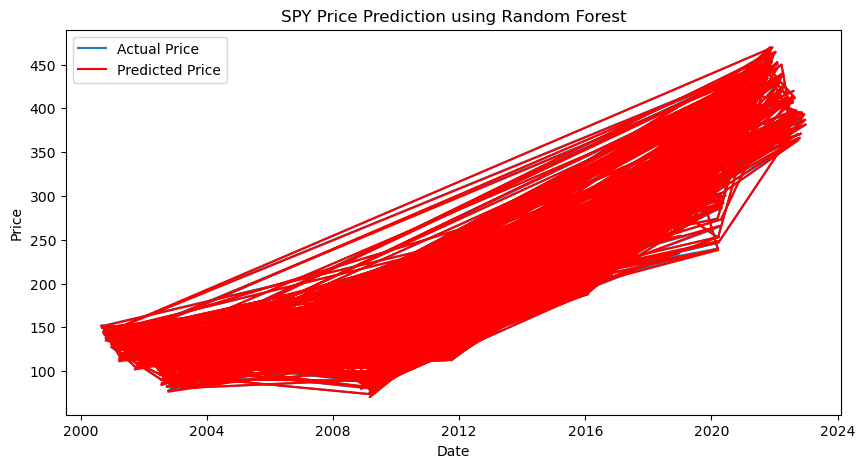

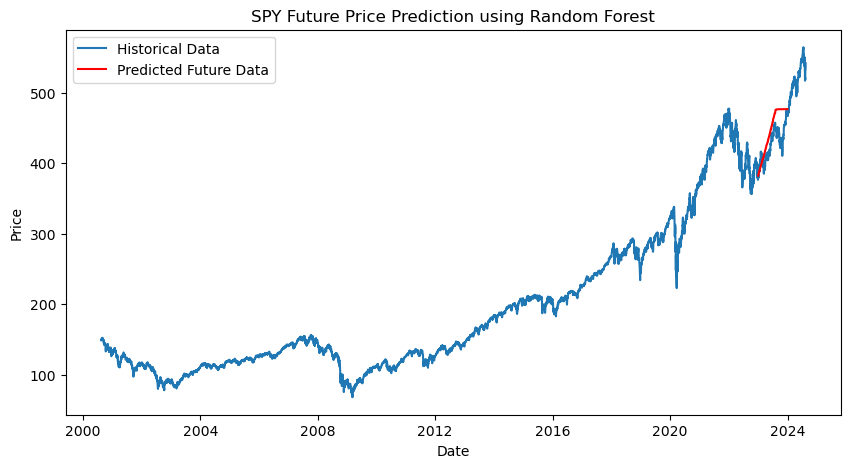

In [20]:
# Use data until the end of 2022 for training
train_until = '2022-12-31'
train_data = combined_df[:train_until]

# Define features and target
X = train_data[['QQQ', 'DIA', 'S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'Russell 2000', 'VIX',
                'MA20', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
y = train_data['SPY']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price', color='red')
plt.title('SPY Price Prediction using Random Forest')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict future prices for 2023 (based on the last data point's features)
future_steps = 365  # Number of future days (approx. 1 year)
X_future = X.iloc[-1:].copy()

future_predictions = []

for i in range(future_steps):
    next_pred = model.predict(scaler.transform(X_future[-1:]))
    future_predictions.append(next_pred[0])
    new_row = pd.DataFrame({
        'QQQ': [X_future['QQQ'].values[-1] * 1.001],  # Assume simple changes for future features
        'DIA': [X_future['DIA'].values[-1] * 1.001],
        'S&P 500': [X_future['S&P 500'].values[-1] * 1.001],
        'Dow Jones Industrial Average': [X_future['Dow Jones Industrial Average'].values[-1] * 1.001],
        'NASDAQ Composite': [X_future['NASDAQ Composite'].values[-1] * 1.001],
        'Russell 2000': [X_future['Russell 2000'].values[-1] * 1.001],
        'VIX': [X_future['VIX'].values[-1] * 1.001],
        'MA20': [X_future['MA20'].values[-1] * 1.001],
        'MA50': [X_future['MA50'].values[-1] * 1.001],
        'MA200': [X_future['MA200'].values[-1] * 1.001],
        'RSI': [X_future['RSI'].values[-1] * 1.001],
        'Upper_BB': [X_future['Upper_BB'].values[-1] * 1.001],
        'Lower_BB': [X_future['Lower_BB'].values[-1] * 1.001]
    }, index=[X_future.index[-1] + pd.DateOffset(days=1)])
    X_future = pd.concat([X_future, new_row])

# Generate dates for the next year
forecast_dates = pd.date_range(start=train_data.index[-1], periods=future_steps + 1)[1:]

# Plot the future prediction results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, future_predictions, label='Predicted Future Data', color='red')
plt.title('SPY Future Price Prediction using Random Forest')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Long Short-Term Memory Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,251 (610.36 KB)

 Trainable params: 156,251 (610.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0063 - val_loss: 0.0181
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0012 - val_loss: 0.0209
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 3.9925e-04 - val_loss: 0.0219
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.2840e-04 - val_loss: 0.0251
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 5.9698e-04 - val_loss: 0.0292
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.4623e-04 - val_loss: 0.0272
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 8.0276e-04 - val_loss: 0.0352
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 5.0389e-04 - val_loss: 0.0350
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 9.7186e-04 - val_loss: 0.0319
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 6.1050e-04 - val_loss: 0.0279
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.4239e-04 - val_loss: 0.0218


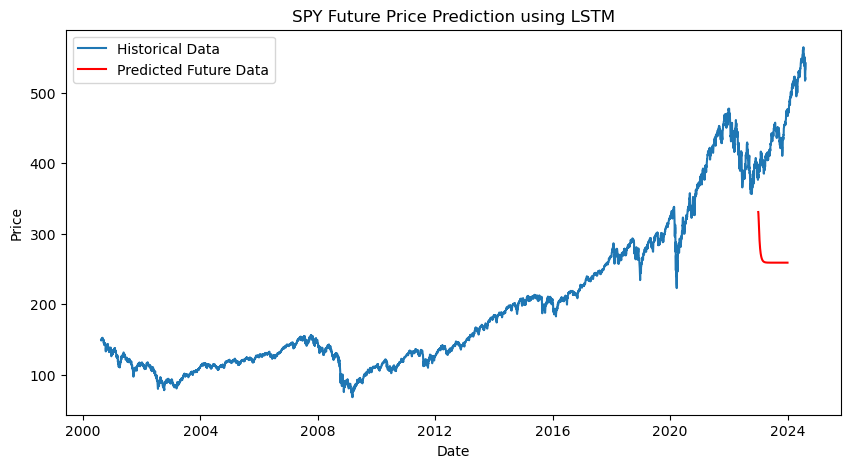

In [22]:
# Define the training data time range
train_until = '2022-12-31'
train_data = combined_df[:train_until]

# Define features and target variable
X = train_data[['QQQ', 'DIA', 'S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'Russell 2000', 'VIX',
                'MA20', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
y = train_data['SPY']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create time series data
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60  # Use the past 60 days to predict the next day's price
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Create and train the LSTM model
model = Sequential()
model.add(Input(shape=(time_steps, X.shape[1])))  # Use Input layer to define input shape
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_seq, y_seq, epochs=50, batch_size=64, validation_split=0.2, shuffle=False, verbose=1, callbacks=[early_stopping])

# Prepare the prediction data for 2023
future_steps = 365  # Predict for 1 year

last_sequence = X_scaled[-time_steps:]  # Use the last 60 days of data to predict
future_predictions = []

for i in range(future_steps):
    next_pred = model.predict(last_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # Update last_sequence by removing the first row and adding the prediction
    next_pred_expanded = np.repeat(next_pred, X.shape[1]).reshape(1, -1)
    last_sequence = np.append(last_sequence[1:], next_pred_expanded, axis=0)

# Inverse transform the predictions
future_predictions = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
forecast_dates = pd.date_range(start='2023-01-01', periods=future_steps)

# Plot the prediction results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, future_predictions, label='Predicted Future Data', color='red')
plt.title('SPY Future Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## GRU Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 100)        │        34,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,951 (460.75 KB)

 Trainable params: 117,951 (460.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 9.2415e-04 - val_loss: 0.0084
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 7.3105e-04 - val_loss: 0.0091
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 5.4891e-04 - val_loss: 0.0063
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 7.4715e-04 - val_loss: 0.0067
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6.1996e-04 - val_loss: 0.0085
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 6.7235e-04 - val_loss: 0.0094
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 4.9756e-04 - val_loss: 0.0047
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.6475e-04 - val_loss: 0.0109
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 4.0616e-04 - val_loss: 0.0109
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 3.9761e-04 - val_loss: 0.0064


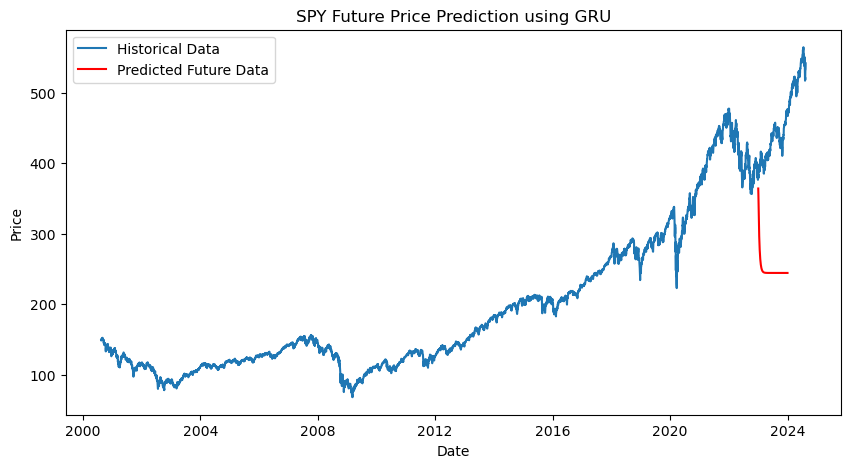

In [24]:
# Define the training data time range
train_until = '2022-12-31'
train_data = combined_df[:train_until]

# Define features and target variable
X = train_data[['QQQ', 'DIA', 'S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'Russell 2000', 'VIX',
                'MA20', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
y = train_data['SPY']

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create time series data
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60  # Use the past 60 days to predict the next day's price
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Create and train the GRU model
model = Sequential()
model.add(Input(shape=(time_steps, X.shape[1])))  # Use Input layer to define input shape
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(100, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_seq, y_seq, epochs=50, batch_size=64, validation_split=0.2, shuffle=False, verbose=1, callbacks=[early_stopping])

# Prepare the prediction data for 2023
future_steps = 365  # Predict for 1 year

last_sequence = X_scaled[-time_steps:]  # Use the last 60 days of data to predict
future_predictions = []

for i in range(future_steps):
    next_pred = model.predict(last_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # Update last_sequence by removing the first row and adding the prediction
    next_pred_expanded = np.repeat(next_pred, X.shape[1]).reshape(1, -1)
    last_sequence = np.append(last_sequence[1:], next_pred_expanded, axis=0)

# Inverse transform the predictions
future_predictions = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
forecast_dates = pd.date_range(start='2023-01-01', periods=future_steps)

# Plot the prediction results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, future_predictions, label='Predicted Future Data', color='red')
plt.title('SPY Future Price Prediction using GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Transformer Model

Epoch 1/50
70/70 - 6s - 80ms/step - loss: 0.0382 - val_loss: 0.2457 - learning_rate: 0.0010
Epoch 2/50
70/70 - 2s - 34ms/step - loss: 0.0255 - val_loss: 0.3010 - learning_rate: 0.0010
Epoch 3/50
70/70 - 3s - 36ms/step - loss: 0.0306 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 4/50
70/70 - 3s - 36ms/step - loss: 0.0391 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 5/50
70/70 - 3s - 39ms/step - loss: 0.0312 - val_loss: 0.4135 - learning_rate: 0.0010
Epoch 6/50
70/70 - 3s - 37ms/step - loss: 0.0315 - val_loss: 0.2373 - learning_rate: 0.0010
Epoch 7/50
70/70 - 3s - 37ms/step - loss: 0.0264 - val_loss: 0.2118 - learning_rate: 0.0010
Epoch 8/50
70/70 - 3s - 38ms/step - loss: 0.0271 - val_loss: 0.2001 - learning_rate: 0.0010
Epoch 9/50
70/70 - 2s - 35ms/step - loss: 0.0271 - val_loss: 0.3408 - learning_rate: 2.0000e-04
Epoch 10/50
70/70 - 3s - 36ms/step - loss: 0.0251 - val_loss: 0.2988 - learning_rate: 2.0000e-04
Epoch 11/50
70/70 - 3s - 36ms/step - loss: 0.0231 - val_loss: 0.2958 - 

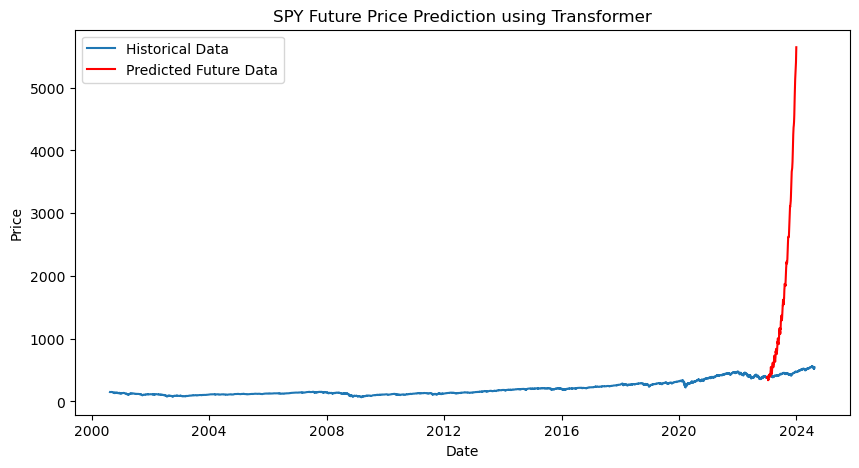

In [26]:
# Custom Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Prepare and combine data for Transformer model
def prepare_data_for_transformer(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Use data until the end of 2022 for training
train_until = '2022-12-31'
train_data = combined_df[:train_until]

# Standardize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Prepare data for Transformer model
time_steps = 60
X, y = prepare_data_for_transformer(train_data_scaled, time_steps)

# Build Transformer model
input_shape = X.shape[1:]
inputs = Input(shape=input_shape)
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=128, dropout=0.2)
x = GlobalAveragePooling1D(data_format="channels_first")(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

# Early stopping and learning rate reduction to avoid overfitting and improve convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, shuffle=False, verbose=2, callbacks=[early_stopping, reduce_lr])

# Prepare the prediction data for 2023
future_steps = 365  # Predicting for one year
last_sequence = train_data_scaled[-time_steps:]
future_predictions = []

for i in range(future_steps):
    next_pred = model.predict(last_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    new_row = np.append(last_sequence[-1, 1:], next_pred[0, 0]).reshape(1, -1)
    last_sequence = np.vstack((last_sequence[1:], new_row))

# Inverse transform only the predicted SPY prices
spy_predictions = np.array(future_predictions).reshape(-1, 1)
spy_predictions = scaler.inverse_transform(np.concatenate([np.zeros((spy_predictions.shape[0], train_data_scaled.shape[1]-1)), spy_predictions], axis=1))[:, -1]

# Generate dates for the predictions
forecast_dates = pd.date_range(start=train_data.index[-1], periods=future_steps + 1)[1:]

# Plot the future prediction results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, spy_predictions, label='Predicted Future Data', color='red')
plt.title('SPY Future Price Prediction using Transformer')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## XGBoost Model

Mean Squared Error: 0.6230775520113724
Root Mean Squared Error: 0.7893526157626719
Mean Absolute Error: 0.5073944174767345
R^2 Score: 0.9999467191033453


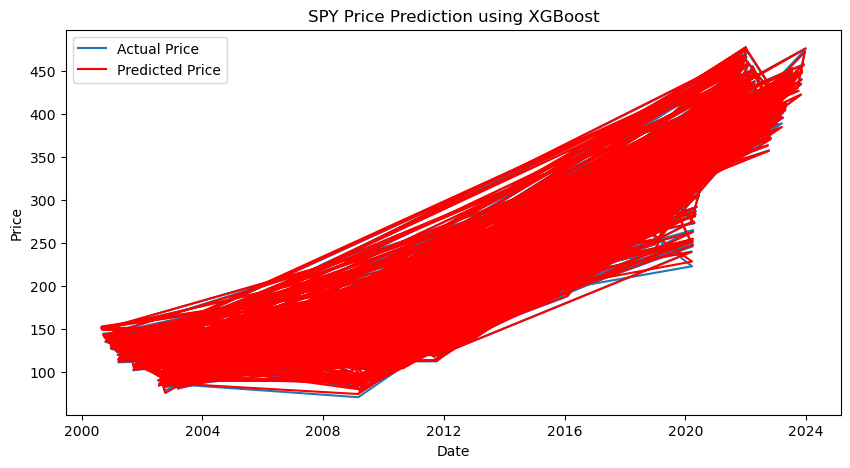

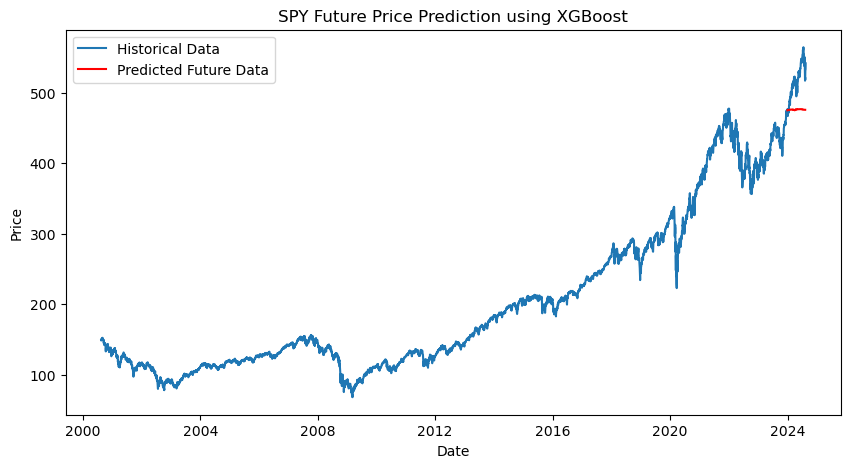

In [28]:
# Use data until the end of 2023 for training
train_until = '2023-12-31'
train_data = combined_df[:train_until]

# Define features and target
X = train_data[['QQQ', 'DIA', 'S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'Russell 2000', 'VIX',
                'MA20', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
y = train_data['SPY']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=200, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = xgb_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price', color='red')
plt.title('SPY Price Prediction using XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict future prices for 2024 (based on the last data point's features)
future_steps = (pd.Timestamp('2024-08-07') - pd.Timestamp(train_data.index[-1])).days  # Number of future days
X_future = X.iloc[-1:].copy()

future_predictions = []

for i in range(future_steps):
    next_pred = xgb_model.predict(scaler.transform(X_future[-1:]))
    future_predictions.append(next_pred[0])
    new_row = pd.DataFrame({
        'QQQ': [X_future['QQQ'].values[-1] * 1.001],  # Assume simple changes for future features
        'DIA': [X_future['DIA'].values[-1] * 1.001],
        'S&P 500': [X_future['S&P 500'].values[-1] * 1.001],
        'Dow Jones Industrial Average': [X_future['Dow Jones Industrial Average'].values[-1] * 1.001],
        'NASDAQ Composite': [X_future['NASDAQ Composite'].values[-1] * 1.001],
        'Russell 2000': [X_future['Russell 2000'].values[-1] * 1.001],
        'VIX': [X_future['VIX'].values[-1] * 1.001],
        'MA20': [X_future['MA20'].values[-1] * 1.001],
        'MA50': [X_future['MA50'].values[-1] * 1.001],
        'MA200': [X_future['MA200'].values[-1] * 1.001],
        'RSI': [X_future['RSI'].values[-1] * 1.001],
        'Upper_BB': [X_future['Upper_BB'].values[-1] * 1.001],
        'Lower_BB': [X_future['Lower_BB'].values[-1] * 1.001]
    }, index=[X_future.index[-1] + pd.DateOffset(days=1)])
    X_future = pd.concat([X_future, new_row])

# Generate dates for the next year
forecast_dates = pd.date_range(start=train_data.index[-1], periods=future_steps + 1)[1:]

# Plot the future prediction results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, future_predictions, label='Predicted Future Data', color='red')
plt.title('SPY Future Price Prediction using XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## LightGBM Model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 13
[LightGBM] [Info] Start training from score 198.419891
Mean Squared Error: 0.5019099945050634
Root Mean Squared Error: 0.7084560639200312
Mean Absolute Error: 0.45878357164715944
R^2 Score: 0.9999570804397288


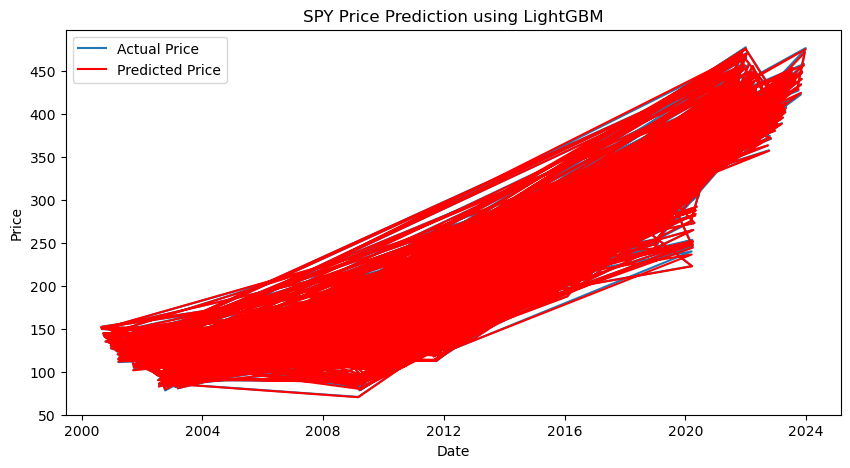

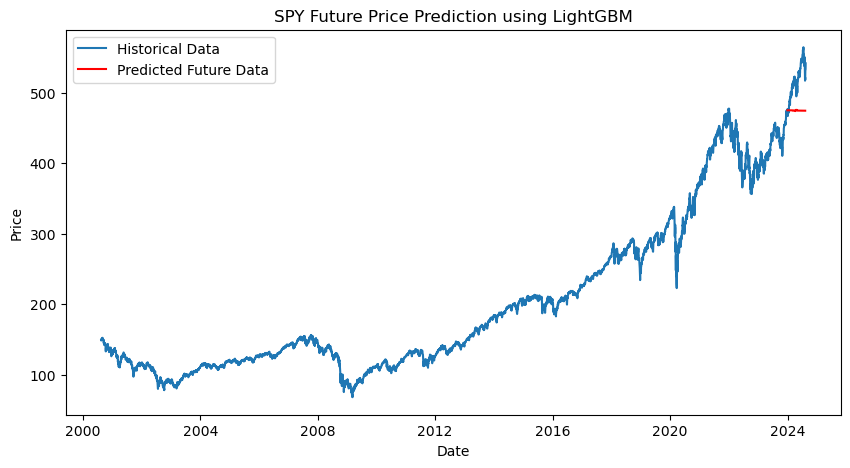

In [30]:
# Use data until the end of 2022 for training
train_until = '2023-12-31'
train_data = combined_df[:train_until]

# Define features and target
X = train_data[['QQQ', 'DIA', 'S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'Russell 2000', 'VIX',
                'MA20', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
y = train_data['SPY']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=200, random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lgb_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, y_pred, label='Predicted Price', color='red')
plt.title('SPY Price Prediction using LightGBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict future prices for 2024 (based on the last data point's features)
future_steps = (pd.Timestamp('2024-08-07') - pd.Timestamp(train_data.index[-1])).days  # Number of future days
X_future = X.iloc[-1:].copy()

future_predictions = []

for i in range(future_steps):
    next_pred = lgb_model.predict(scaler.transform(X_future[-1:]))
    future_predictions.append(next_pred[0])
    new_row = pd.DataFrame({
        'QQQ': [X_future['QQQ'].values[-1] * 1.001],  # Assume simple changes for future features
        'DIA': [X_future['DIA'].values[-1] * 1.001],
        'S&P 500': [X_future['S&P 500'].values[-1] * 1.001],
        'Dow Jones Industrial Average': [X_future['Dow Jones Industrial Average'].values[-1] * 1.001],
        'NASDAQ Composite': [X_future['NASDAQ Composite'].values[-1] * 1.001],
        'Russell 2000': [X_future['Russell 2000'].values[-1] * 1.001],
        'VIX': [X_future['VIX'].values[-1] * 1.001],
        'MA20': [X_future['MA20'].values[-1] * 1.001],
        'MA50': [X_future['MA50'].values[-1] * 1.001],
        'MA200': [X_future['MA200'].values[-1] * 1.001],
        'RSI': [X_future['RSI'].values[-1] * 1.001],
        'Upper_BB': [X_future['Upper_BB'].values[-1] * 1.001],
        'Lower_BB': [X_future['Lower_BB'].values[-1] * 1.001]
    }, index=[X_future.index[-1] + pd.DateOffset(days=1)])
    X_future = pd.concat([X_future, new_row])

# Generate dates for the next year
forecast_dates = pd.date_range(start=train_data.index[-1], periods=future_steps + 1)[1:]

# Plot the future prediction results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, future_predictions, label='Predicted Future Data', color='red')
plt.title('SPY Future Price Prediction using LightGBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## CNN-LSTM model

Epoch 1/50


D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 - 6s - 87ms/step - loss: 0.0208 - val_loss: 0.0516
Epoch 2/50
70/70 - 3s - 48ms/step - loss: 0.0161 - val_loss: 0.0300
Epoch 3/50
70/70 - 3s - 45ms/step - loss: 0.0159 - val_loss: 0.0362
Epoch 4/50
70/70 - 3s - 45ms/step - loss: 0.0156 - val_loss: 0.0300
Epoch 5/50
70/70 - 3s - 46ms/step - loss: 0.0155 - val_loss: 0.0330
Epoch 6/50
70/70 - 3s - 45ms/step - loss: 0.0154 - val_loss: 0.0432
Epoch 7/50
70/70 - 3s - 44ms/step - loss: 0.0153 - val_loss: 0.0381
Epoch 8/50
70/70 - 3s - 47ms/step - loss: 0.0152 - val_loss: 0.0368
Epoch 9/50
70/70 - 3s - 45ms/step - loss: 0.0152 - val_loss: 0.0414
Epoch 10/50
70/70 - 3s - 45ms/step - loss: 0.0151 - val_loss: 0.0501
Epoch 11/50
70/70 - 3s - 43ms/step - loss: 0.0151 - val_loss: 0.0460
Epoch 12/50
70/70 - 3s - 47ms/step - loss: 0.0151 - val_loss: 0.0458
Epoch 13/50
70/70 - 3s - 45ms/step - loss: 0.0151 - val_loss: 0.0473
Epoch 14/50
70/70 - 3s - 46ms/step - loss: 0.0150 - val_loss: 0.0419


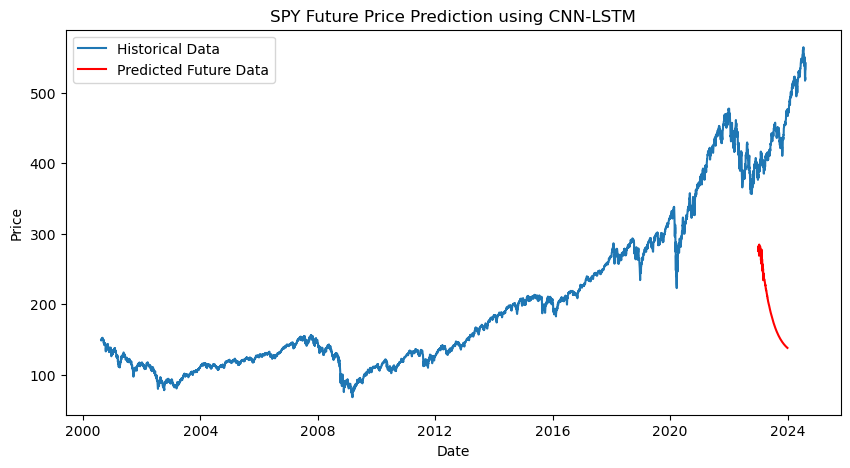

In [32]:
# Prepare and combine data for CNN-LSTM model
def prepare_data_for_cnn_lstm(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Use data until the end of 2022 for training
train_until = '2022-12-31'
train_data = combined_df[:train_until]

# Standardize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Prepare data for CNN-LSTM model
time_steps = 60
X, y = prepare_data_for_cnn_lstm(train_data_scaled, time_steps)

# Build CNN-LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    RepeatVector(time_steps),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, verbose=2, callbacks=[early_stopping])

# Prepare the prediction data for 2023
future_steps = 365  # Predicting for one year
last_sequence = train_data_scaled[-time_steps:]
future_predictions = []

for i in range(future_steps):
    next_pred = model.predict(last_sequence[np.newaxis, :, :], verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # Update last_sequence by removing the first row and adding the prediction
    new_row = np.append(last_sequence[-1, 1:], next_pred[0, 0]).reshape(1, -1)
    last_sequence = np.vstack((last_sequence[1:], new_row))

# Inverse transform only the predicted SPY prices
spy_predictions = np.array(future_predictions).reshape(-1, 1)
spy_predictions = scaler.inverse_transform(np.concatenate([np.zeros((spy_predictions.shape[0], train_data_scaled.shape[1]-1)), spy_predictions], axis=1))[:, -1]

# Generate dates for the predictions
forecast_dates = pd.date_range(start=train_data.index[-1], periods=future_steps + 1)[1:]

# Plot the future prediction results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, spy_predictions, label='Predicted Future Data', color='red')
plt.title('SPY Future Price Prediction using CNN-LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Prophet Model

02:22:13 - cmdstanpy - INFO - Chain [1] start processing
02:22:14 - cmdstanpy - INFO - Chain [1] done processing


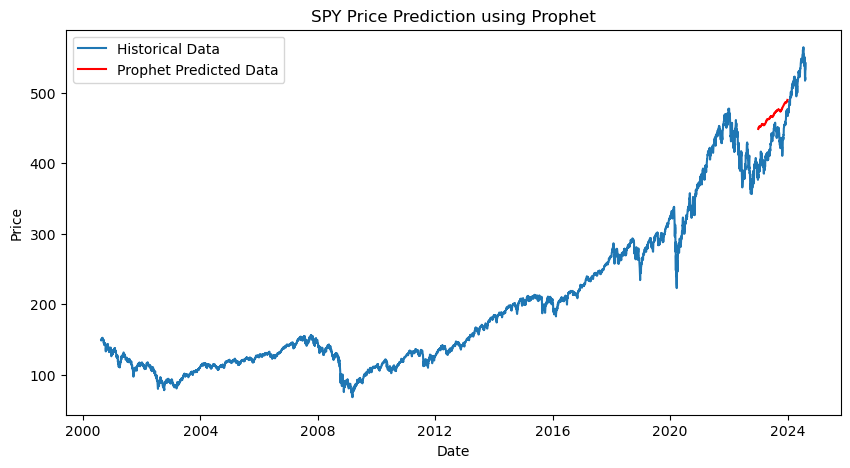

In [34]:
# Use data until the end of 2022 for training
train_until = '2022-12-31'
train_data = combined_df[:train_until]

# Prepare data for Prophet
df_prophet = train_data[['SPY']].reset_index()
df_prophet.rename(columns={'index': 'ds', 'SPY': 'y'}, inplace=True)

# Initialize and fit the Prophet model with adjusted parameters
model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.5, seasonality_prior_scale=10.0)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)

# Make future predictions for the next year
future_dates = model.make_future_dataframe(periods=365)
forecast = model.predict(future_dates)

# Extract the predicted values from Prophet and align them with the actual future dates
prophet_pred = forecast[['ds', 'yhat']].set_index('ds')['yhat']
prophet_pred = prophet_pred.loc['2023-01-01':'2023-12-31']

# Plot the historical data and Prophet predictions
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(prophet_pred.index, prophet_pred, label='Prophet Predicted Data', color='red')
plt.title('SPY Price Prediction using Prophet')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## SARIMAX Model

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: 

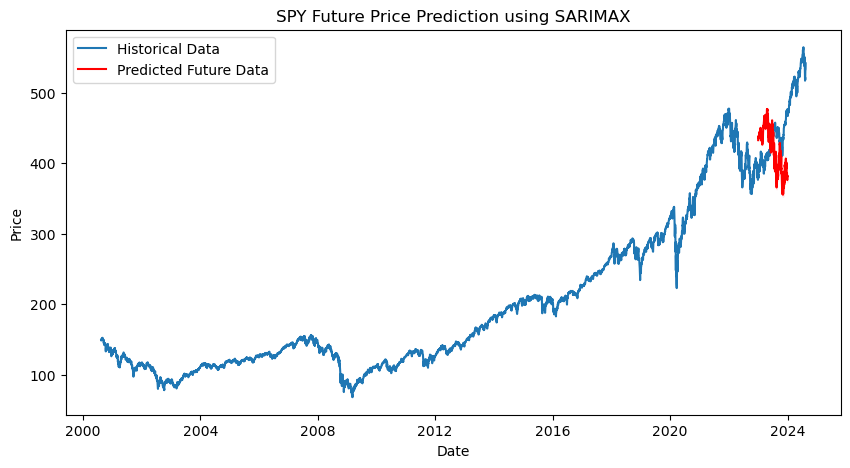

In [36]:
# Use data until the end of 2022 for training
train_until = '2022-12-31'
train_data = combined_df[:train_until]

# Define features and target
X = train_data[['QQQ', 'DIA', 'S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'Russell 2000', 'VIX',
                'MA20', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
y = train_data['SPY']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with the scaled features and target
train_data_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
train_data_scaled['SPY'] = y

# Define the exogenous variables
exog = train_data_scaled.drop(columns=['SPY'])

# Fit the SARIMAX model
model = SARIMAX(train_data_scaled['SPY'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog)
results = model.fit()

# Forecast the future prices for 2023
future_steps = 365

# Generate dates for the forecast with daily frequency
forecast_dates = pd.date_range(start=train_data.index[-1], periods=future_steps + 1, freq='D')[1:]

# Create a new exog DataFrame for the forecasting period
exog_future = pd.DataFrame(scaler.transform(X.iloc[-future_steps:]), columns=X.columns, index=forecast_dates)

# Make SARIMAX predictions
forecast = results.get_forecast(steps=future_steps, exog=exog_future)
sarimax_forecast = forecast.predicted_mean  # Store SARIMAX predictions as sarimax_forecast
forecast_conf_int = forecast.conf_int()

# Ensure the forecasted values have the correct date index
sarimax_forecast.index = forecast_dates

# Plot the forecast results
plt.figure(figsize=(10, 5))
plt.plot(combined_df.index, combined_df['SPY'], label='Historical Data')
plt.plot(forecast_dates, sarimax_forecast, label='Predicted Future Data', color='red')
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SPY Future Price Prediction using SARIMAX')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



## Designing a Combined Model based on Random Forest Regressor, SARIMAX and Prophet

02:24:04 - cmdstanpy - INFO - Chain [1] start processing
02:24:06 - cmdstanpy - INFO - Chain [1] done processing
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  

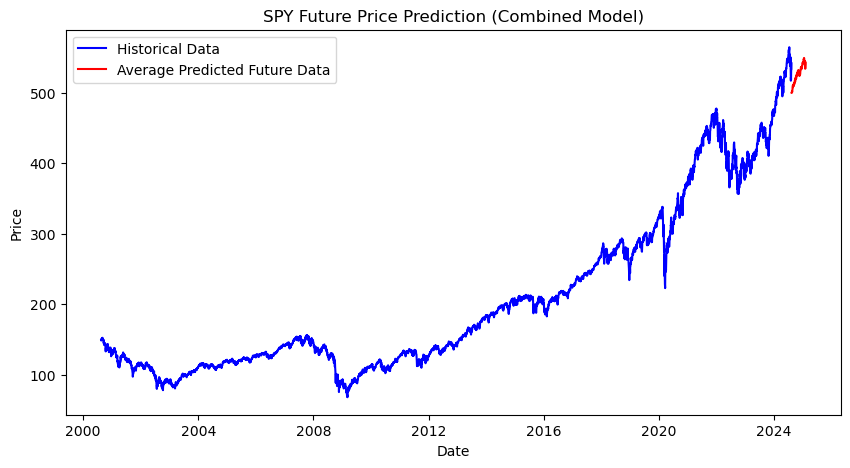

In [38]:
# Define the function for combined model forecasting
def combined_etf_prediction(etf_symbol, prediction_days):
    # Use the latest data
    train_until = datetime.today().strftime('%Y-%m-%d')
    train_data = combined_df[:train_until]

    # Step 1: Prophet model
    # Prepare data for Prophet
    df_prophet = train_data[[etf_symbol]].reset_index()
    df_prophet.rename(columns={'index': 'ds', etf_symbol: 'y'}, inplace=True)

    # Initialize and fit the Prophet model
    prophet_model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.5, seasonality_prior_scale=10.0)
    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    prophet_model.fit(df_prophet)

    # Make future predictions with Prophet
    future_dates_prophet = prophet_model.make_future_dataframe(periods=prediction_days)
    forecast_prophet = prophet_model.predict(future_dates_prophet)

    # Extract Prophet predictions and align with forecast dates
    prophet_forecast = forecast_prophet[['ds', 'yhat']].set_index('ds')['yhat']
    prophet_forecast = prophet_forecast.loc[future_dates_prophet['ds'].min():future_dates_prophet['ds'].max()]

    # Step 2: SARIMAX model
    # Define features and target
    X = train_data[['QQQ', 'DIA', 'S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'Russell 2000', 'VIX',
                    'MA20', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
    y = train_data[etf_symbol]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create DataFrame with scaled features and target
    train_data_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    train_data_scaled[etf_symbol] = y

    # Define exogenous variables and fit SARIMAX model
    exog = train_data_scaled.drop(columns=[etf_symbol])
    sarimax_model = SARIMAX(train_data_scaled[etf_symbol], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=exog)
    sarimax_results = sarimax_model.fit()

    # Create new exog DataFrame for the forecasting period
    forecast_dates = pd.date_range(start=train_data.index[-1], periods=prediction_days + 1)[1:]
    exog_future = pd.DataFrame(scaler.transform(X.iloc[-prediction_days:]), columns=X.columns, index=forecast_dates)

    # Make SARIMAX predictions
    forecast_sarimax = sarimax_results.get_forecast(steps=prediction_days, exog=exog_future)
    sarimax_forecast = forecast_sarimax.predicted_mean

    # Ensure SARIMAX predictions have the correct date index
    sarimax_forecast.index = forecast_dates

    # Step 3: Random Forest model
    # Split the data for Random Forest
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Predict future prices with Random Forest
    X_future = X.iloc[-1:].copy()
    future_predictions = []

    for i in range(prediction_days):
        next_pred = rf_model.predict(scaler.transform(X_future[-1:]))
        future_predictions.append(next_pred[0])
        new_row = pd.DataFrame({
            'QQQ': [X_future['QQQ'].values[-1] * 1.001],  
            'DIA': [X_future['DIA'].values[-1] * 1.001],
            'S&P 500': [X_future['S&P 500'].values[-1] * 1.001],
            'Dow Jones Industrial Average': [X_future['Dow Jones Industrial Average'].values[-1] * 1.001],
            'NASDAQ Composite': [X_future['NASDAQ Composite'].values[-1] * 1.001],
            'Russell 2000': [X_future['Russell 2000'].values[-1] * 1.001],
            'VIX': [X_future['VIX'].values[-1] * 1.001],
            'MA20': [X_future['MA20'].values[-1] * 1.001],
            'MA50': [X_future['MA50'].values[-1] * 1.001],
            'MA200': [X_future['MA200'].values[-1] * 1.001],
            'RSI': [X_future['RSI'].values[-1] * 1.001],
            'Upper_BB': [X_future['Upper_BB'].values[-1] * 1.001],
            'Lower_BB': [X_future['Lower_BB'].values[-1] * 1.001]
        }, index=[X_future.index[-1] + pd.DateOffset(days=1)])
        X_future = pd.concat([X_future, new_row])

    # Align Random Forest predictions with forecast dates
    rf_forecast = pd.Series(future_predictions, index=forecast_dates)

    # Combine the predictions by averaging them
    combined_forecast = (prophet_forecast + sarimax_forecast + rf_forecast) / 3

    # Plot the combined predictions along with historical data
    plt.figure(figsize=(10, 5))
    plt.plot(combined_df.index, combined_df[etf_symbol], label='Historical Data', color='blue')
    plt.plot(combined_forecast.index, combined_forecast, label='Average Predicted Future Data', color='red')
    plt.title(f'{etf_symbol} Future Price Prediction (Combined Model)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example usage
combined_etf_prediction('SPY', 180)

## Investment Strategies

### Dollar-Cost Averaging with Increment Factor

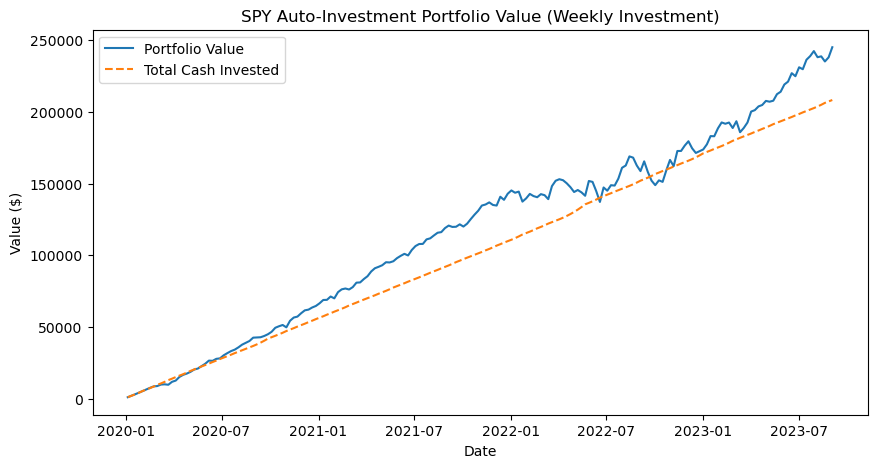

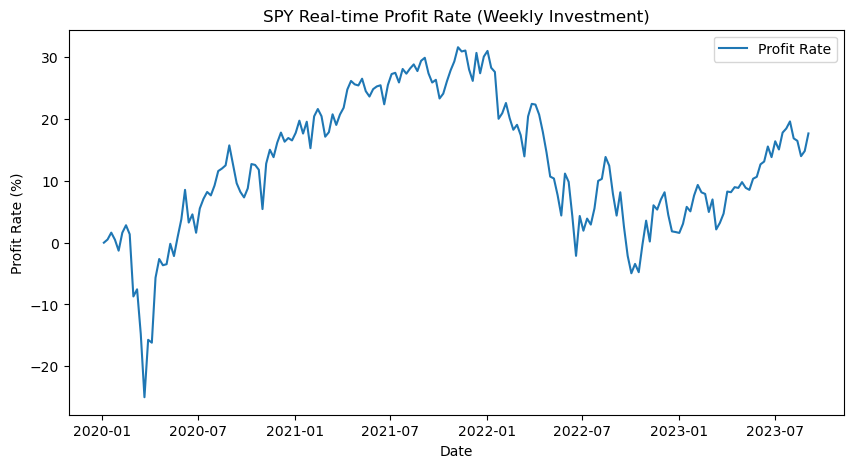

Total cash invested: $208212.09
Final portfolio value: $245011.87
Profit rate: 17.67%
Total profit: $36799.78


In [179]:
def simulate_auto_investment_with_profit_rate(etf_symbol, start_date, end_date, interval='weekly', initial_investment=1000, increment_factor=1.1):
    # Extract the relevant data for the ETF within the specified date range
    etf_data = combined_df[etf_symbol][start_date:end_date]

    # Define the interval for auto-investment
    if interval == 'weekly':
        freq = 'W'
    elif interval == 'bi-weekly':
        freq = '2W'
    elif interval == 'monthly':
        freq = 'M'
    else:
        raise ValueError("Interval must be 'weekly', 'bi-weekly', or 'monthly'.")

    # Resample the data to match the investment interval
    etf_data_resampled = etf_data.resample(freq).last()

    # Initialize variables for the simulation
    cash_invested = 0
    shares_owned = 0
    total_investment = initial_investment
    portfolio_value_history = []
    cash_invested_history = []
    profit_rate_history = []
    total_profit_history = []

    # Run the simulation over the resampled data
    for i in range(0, len(etf_data_resampled)):
        current_price = etf_data_resampled.iloc[i]
        
        if i == 0:  # First investment
            shares_purchased = total_investment / current_price
            shares_owned += shares_purchased
            cash_invested += total_investment
            portfolio_value = shares_owned * current_price
            portfolio_value_history.append(portfolio_value)
            cash_invested_history.append(cash_invested)
            profit_rate_history.append((portfolio_value - cash_invested) / cash_invested * 100)
            total_profit_history.append(portfolio_value - cash_invested)
            continue
        
        previous_price = etf_data_resampled.iloc[i-1]

        # Determine the investment amount based on price movement
        if current_price < previous_price:
            total_investment *= increment_factor  # Increase investment if the price drops
        else:
            total_investment = initial_investment  # Reset to initial investment if price doesn't drop

        # Calculate the number of shares to purchase
        shares_purchased = total_investment / current_price
        shares_owned += shares_purchased
        cash_invested += total_investment

        # Record the portfolio value and cash invested
        portfolio_value = shares_owned * current_price
        portfolio_value_history.append(portfolio_value)
        cash_invested_history.append(cash_invested)

        # Calculate and store the profit rate
        profit_rate = (portfolio_value - cash_invested) / cash_invested * 100
        profit_rate_history.append(profit_rate)
        
        # Calculate and store the total profit
        total_profit = portfolio_value - cash_invested
        total_profit_history.append(total_profit)

    # Final portfolio value and profit rate calculation
    final_portfolio_value = portfolio_value_history[-1]
    final_cash_invested = cash_invested_history[-1]
    final_profit_rate = profit_rate_history[-1]
    final_total_profit = total_profit_history[-1]

    # Plot the investment value and cash invested over time
    plt.figure(figsize=(10, 5))
    plt.plot(etf_data_resampled.index, portfolio_value_history, label='Portfolio Value')
    plt.plot(etf_data_resampled.index, cash_invested_history, label='Total Cash Invested', linestyle='--')
    plt.title(f'{etf_symbol} Auto-Investment Portfolio Value ({interval.capitalize()} Investment)')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()

    # Plot the profit rate over time
    plt.figure(figsize=(10, 5))
    plt.plot(etf_data_resampled.index, profit_rate_history, label='Profit Rate')
    plt.title(f'{etf_symbol} Real-time Profit Rate ({interval.capitalize()} Investment)')
    plt.xlabel('Date')
    plt.ylabel('Profit Rate (%)')
    plt.legend()
    plt.show()

    print(f"Total cash invested: ${final_cash_invested:.2f}")
    print(f"Final portfolio value: ${final_portfolio_value:.2f}")
    print(f"Profit rate: {final_profit_rate:.2f}%")
    print(f"Total profit: ${final_total_profit:.2f}")

# Example usage
simulate_auto_investment_with_profit_rate('SPY', '2020-01-01', '2023-09-01', interval='weekly', initial_investment=1000, increment_factor=1.1)


### Mean Reversion Strategy

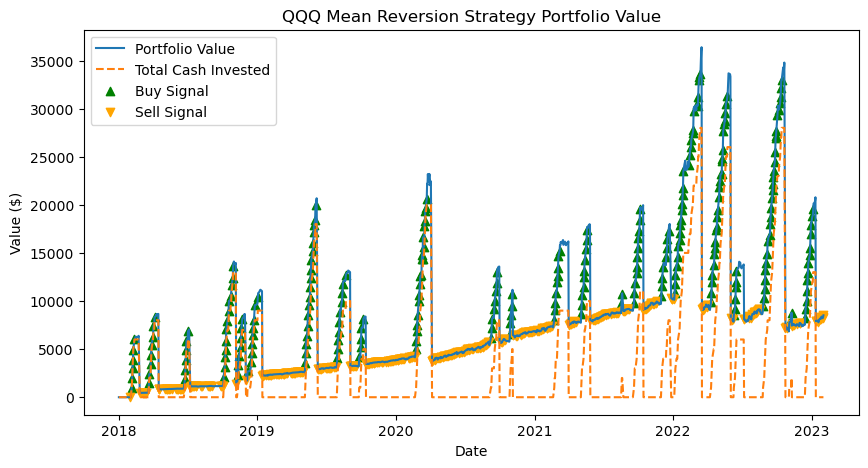

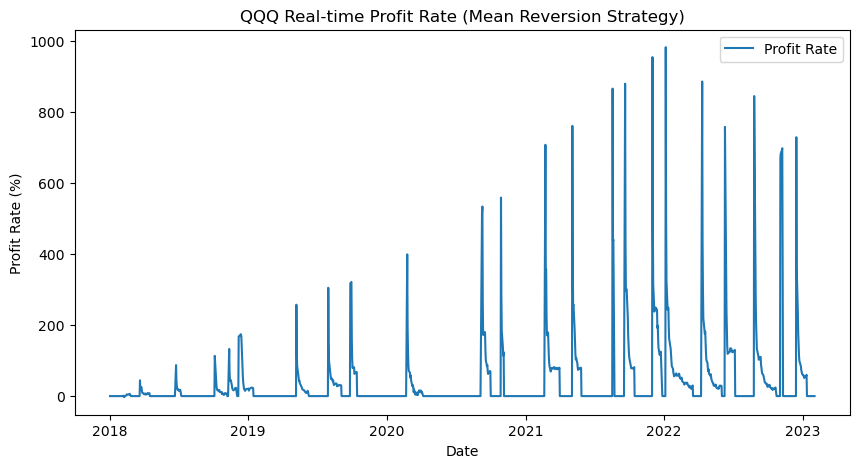

Total cash invested: $0.00
Final portfolio value: $8512.91
Profit rate: 0.00%
Total profit: $8512.91


In [177]:
def mean_reversion_strategy_with_profit_rate(combined_df, symbol, start_date, end_date, window=20, z_threshold=1.0, initial_investment=1000):
    # Filter the data for the selected ETF symbol and date range
    df = combined_df.loc[start_date:end_date, [symbol]].copy()

    # Calculate rolling mean and standard deviation
    df['MA'] = df[symbol].rolling(window=window).mean()
    df['STD'] = df[symbol].rolling(window=window).std()
    df['Z_Score'] = (df[symbol] - df['MA']) / df['STD']
    
    # Generate buy/sell signals
    df['Buy_Signal'] = np.where(df['Z_Score'] < -z_threshold, 1, 0)
    df['Sell_Signal'] = np.where(df['Z_Score'] > z_threshold, -1, 0)
    
    # Initialize investment variables
    cash_invested = 0
    shares_owned = 0
    total_investment = initial_investment
    portfolio_value_history = []
    cash_invested_history = []
    profit_rate_history = []
    total_profit_history = []

    # Simulate the strategy
    for i in range(len(df)):
        current_price = df[symbol].iloc[i]
        
        if df['Buy_Signal'].iloc[i] == 1:
            shares_purchased = total_investment / current_price
            shares_owned += shares_purchased
            cash_invested += total_investment
            total_investment = initial_investment  # Reset investment amount after buy
        elif df['Sell_Signal'].iloc[i] == -1 and shares_owned > 0:
            # Calculate the value of shares to be sold
            sale_value = shares_owned * current_price
            potential_cash_invested = cash_invested - sale_value

            # If selling all shares would make cash_invested negative, sell only enough to make it zero
            if potential_cash_invested < 0:
                shares_to_sell = cash_invested / current_price
                shares_owned -= shares_to_sell
                cash_invested = 0
            else:
                shares_owned = 0  # Selling all shares
                cash_invested -= sale_value

        # Update portfolio value
        portfolio_value = shares_owned * current_price
        portfolio_value_history.append(portfolio_value)
        cash_invested_history.append(cash_invested)
        
        # Calculate profit rate
        profit_rate = (portfolio_value - cash_invested) / cash_invested * 100 if cash_invested > 0 else 0
        profit_rate_history.append(profit_rate)
        
        # Calculate total profit
        total_profit = portfolio_value - cash_invested
        total_profit_history.append(total_profit)

    # Final portfolio value and profit rate calculation
    final_portfolio_value = portfolio_value_history[-1]
    final_cash_invested = cash_invested_history[-1]
    final_profit_rate = profit_rate_history[-1]
    final_total_profit = total_profit_history[-1]

    # Plot the investment value and cash invested over time
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, portfolio_value_history, label='Portfolio Value')
    plt.plot(df.index, cash_invested_history, label='Total Cash Invested', linestyle='--')
    plt.scatter(df.index, np.where(df['Buy_Signal'] == 1, portfolio_value_history, np.nan), 
                marker='^', color='green', label='Buy Signal')
    plt.scatter(df.index, np.where(df['Sell_Signal'] == -1, portfolio_value_history, np.nan), 
                marker='v', color='orange', label='Sell Signal')
    plt.title(f'{symbol} Mean Reversion Strategy Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()

    # Plot the profit rate over time
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, profit_rate_history, label='Profit Rate')
    plt.title(f'{symbol} Real-time Profit Rate (Mean Reversion Strategy)')
    plt.xlabel('Date')
    plt.ylabel('Profit Rate (%)')
    plt.legend()
    plt.show()

    print(f"Total cash invested: ${final_cash_invested:.2f}")
    print(f"Final portfolio value: ${final_portfolio_value:.2f}")
    print(f"Profit rate: {final_profit_rate:.2f}%")
    print(f"Total profit: ${final_total_profit:.2f}")

# Example usage
mean_reversion_strategy_with_profit_rate(combined_df, 'QQQ', '2018-01-01', '2023-02-01', window=20, z_threshold=1.0, initial_investment=1000)
